In [ ]:
import pandas as pd
import seaborn as sns

import tensorflow as tf
import numpy as np
import re
import codecs
import os
from nltk.tokenize import RegexpTokenizer

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Bidirectional
from keras.preprocessing import sequence
from keras.layers import Dropout
import h5py
import utility_functions as uf
from keras.models import model_from_json
from keras.models import load_model
from nltk.tokenize import RegexpTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#reading the data
spray = pd.read_csv("/content/drive/My Drive/nndl/spray_sanitized.csv")
spray.drop('Unnamed: 0', axis='columns', inplace=True)

In [ ]:
def load_embeddings(embedding_path):
  """Loads embedings, returns weight matrix and dict from words to indices."""
  print('loading word embeddings from %s' % embedding_path)
  weight_vectors = []
  word_idx = {}
  with codecs.open(embedding_path, encoding='utf-8') as f:
    for line in f:
      word, vec = line.split(u' ', 1)
      word_idx[word] = len(weight_vectors)
      weight_vectors.append(np.array(vec.split(), dtype=np.float32))
  # Annoying implementation detail; '(' and ')' are replaced by '-LRB-' and
  # '-RRB-' respectively in the parse-trees.
  word_idx[u'-LRB-'] = word_idx.pop(u'(')
  word_idx[u'-RRB-'] = word_idx.pop(u')')
  # Random embedding vector for unknown words.
  weight_vectors.append(np.random.uniform(
      -0.05, 0.05, weight_vectors[0].shape).astype(np.float32))
  print('Done !')
  return np.stack(weight_vectors), word_idx

def live_test(trained_model, data, word_idx):

    #data = "Pass the salt"
    #data_sample_list = data.split()
    live_list = []
    live_list_np = np.zeros((56,1))
    # split the sentence into its words and remove any punctuations.
    tokenizer = RegexpTokenizer(r'\w+')
    data_sample_list = tokenizer.tokenize(data)

    labels = np.array(['1','2','3','4','5','6','7','8','9','10'], dtype = "int")
    #word_idx['I']
    # get index for the live stage
    data_index = np.array([word_idx[word.lower()] if word.lower() in word_idx else 0 for word in data_sample_list])
    data_index_np = np.array(data_index)
    #print(data_index_np)

    # padded with zeros of length 56 i.e maximum length
    padded_array = np.zeros(56) # use the def maxSeqLen(training_data) function to detemine the padding length for your data
    padded_array[:data_index_np.shape[0]] = data_index_np
    data_index_np_pad = padded_array.astype(int)
    live_list.append(data_index_np_pad)
    live_list_np = np.asarray(live_list)
    type(live_list_np)

    # get score from the model
    score = trained_model.predict(live_list_np, batch_size=1, verbose=0)
    #print (score)

    single_score = np.round(np.argmax(score)/10, decimals=2) # maximum of the array i.e single band

    # weighted score of top 3 bands
    top_3_index = np.argsort(score)[0][-3:]
    top_3_scores = score[0][top_3_index]
    top_3_weights = top_3_scores/np.sum(top_3_scores)
    single_score_dot = np.round(np.dot(top_3_index, top_3_weights)/10, decimals = 2)

    #print (single_score)
    return single_score_dot

In [ ]:
spray.head()

,Date,Review_text,Review_title,Stars
0,2020-05-30,"150 Rs for 75 ml, very expensive and small bot...",Waste of money.,1
1,2020-05-20,Very helpful and handy product these days.This...,Very helpful and handy product these days. th...,4
2,2020-05-21,I have been looking for sanitizer sprays that ...,Best sanitizer/ disinfectant spray,5
3,2020-05-20,Good one,Awesome product from lifebuoy,5
4,2020-05-23,Good and genuine product,Genuine product,5


In [ ]:
import utility_functions as uf

gloveFile = '/content/drive/My Drive/nndl/Data/glove/glove_6B_100d.txt'
weight_matrix, word_idx = load_embeddings(gloveFile)

loading word embeddings from /content/drive/My Drive/nndl/Data/glove/glove_6B_100d.txt
Done !


In [ ]:
#Load the Model
new_model = tf.keras.models.load_model('/content/drive/My Drive/nndl/model/best_model.hdf5')

In [ ]:
txt = "this is a very good product 10/10 would recommend !!"
result = live_test(new_model, txt, word_idx)
print(result)

0.7


In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 133kB 5.7MB/s 


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

sid_obj = SentimentIntensityAnalyzer() 
dicto = sid_obj.polarity_scores("this is a very good product 10/10 would recommend !!")

print(dicto)

{'neg': 0.0, 'neu': 0.56, 'pos': 0.44, 'compound': 0.7412}


In [ ]:
l = list(spray["Review_text"])
scores = []
indices = []

for i in range(0,len(l)):
    if(len(l[i].split(" ")) < 55):
        scores.append(live_test(new_model, l[i], word_idx))
    else:
        indices.append(i)

In [ ]:
len(scores)

982

In [ ]:
len(spray)

982

In [ ]:
len(indices)

0

In [ ]:
new = spray

In [ ]:
new.drop(new.index[indices], inplace=True)
new = new.reset_index(drop=True)
print(new.head(20))

          Date  ... Stars
0   2020-05-30  ...     1
1   2020-05-21  ...     5
2   2020-05-20  ...     5
3   2020-05-23  ...     5
4   2020-05-24  ...     1
5   2020-05-31  ...     4
6   2020-06-02  ...     1
7   2020-05-23  ...     1
8   2020-06-02  ...     1
9   2020-06-09  ...     1
10  2020-06-08  ...     4
11  2020-06-21  ...     5
12  2020-07-27  ...     5
13  2020-08-07  ...     4
14  2020-08-12  ...     3
15  2020-08-16  ...     1
16  2020-06-24  ...     5
17  2020-06-22  ...     5
18  2020-08-04  ...     2
19  2020-07-23  ...     2

[20 rows x 4 columns]


In [ ]:
new['Score'] = scores
print(new.head(20))

          Date                                        Review_text  ... Stars  Score
0   2020-05-30  150 Rs for 75 ml, very expensive and small bot...  ...     1   0.20
1   2020-05-21  I have been looking for sanitizer sprays that ...  ...     5   0.23
2   2020-05-20                                           Good one  ...     5   0.68
3   2020-05-23                           Good and genuine product  ...     5   0.73
4   2020-05-24        Very expensive.. compared to competition...  ...     1   0.40
5   2020-05-31  Lifebuoy products have always been a hot favou...  ...     4   0.18
6   2020-06-02  I received a damaged product today...paying su...  ...     1   0.10
7   2020-05-23  Not value for money.I always get damaged bottl...  ...     1   0.20
8   2020-06-02                           One of them has not Cap.  ...     1   0.43
9   2020-06-09  Very bad.. Out of 2 bottle 1 is working.. Also...  ...     1   0.09
10  2020-06-08  Very good and effective in this time of Covid ...  ...     4

## VISUALIZATION

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
#converting data to Date_time
new['Date'] = new['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

In [ ]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 982 entries, 0 to 981
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          982 non-null    datetime64[ns]
 1   Review_text   982 non-null    object        
 2   Review_title  982 non-null    object        
 3   Stars         982 non-null    int64         
 4   Score         982 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 38.5+ KB


In [ ]:
new['day'] = new['Date'].dt.day
new['month'] = new['Date'].dt.month
new['year'] = new['Date'].dt.year

In [ ]:
new.head(15)

,Date,Review_text,Review_title,Stars,Score,day,month,year
0,2020-05-30,"150 Rs for 75 ml, very expensive and small bot...",Waste of money.,1,0.20,30,5,2020
1,2020-05-21,I have been looking for sanitizer sprays that ...,Best sanitizer/ disinfectant spray,5,0.23,21,5,2020
2,2020-05-20,Good one,Awesome product from lifebuoy,5,0.68,20,5,2020
3,2020-05-23,Good and genuine product,Genuine product,5,0.73,23,5,2020
4,2020-05-24,Very expensive.. compared to competition...,Very expensive for size,1,0.40,24,5,2020
5,2020-05-31,Lifebuoy products have always been a hot favou...,Germ but not Virus Spray,4,0.18,31,5,2020
6,2020-06-02,I received a damaged product today...paying su...,Received damaged product,1,0.10,2,6,2020
7,2020-05-23,Not value for money.I always get damaged bottl...,I always get damaged bottle. Not value for money.,1,0.20,23,5,2020
8,2020-06-02,One of them has not Cap.,Dishonest Seller,1,0.43,2,6,2020
9,2020-06-09,Very bad.. Out of 2 bottle 1 is working.. Also...,Worst product and seller,1,0.09,9,6,2020


In [ ]:
temp_p = new.loc[new['Score'] > 0.55]
temp_nu = new.loc[((new['Score'] > 0.45) & (new['Score'] < 0.55))]
temp_n = new.loc[new['Score'] < 0.45]

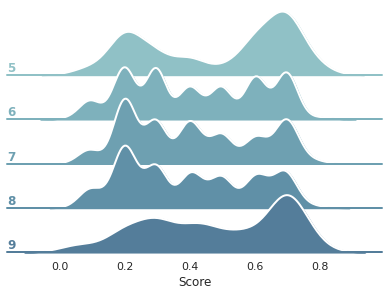

In [ ]:
import pandas as pd
import seaborn as sns

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(new, row="month", hue="month", aspect=6.6, height=.9, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Score",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "Score", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Score")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.35)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

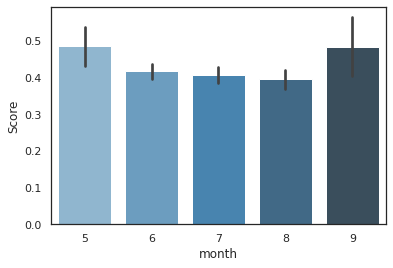

In [ ]:
sns.barplot(x="month", y="Score", data=new, palette="Blues_d")

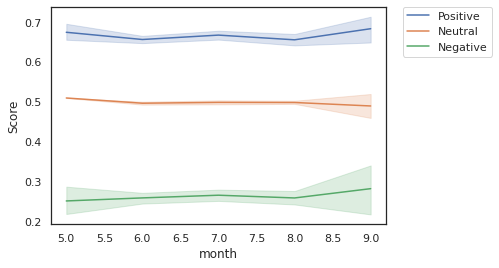

In [ ]:
sns.lineplot(x="month", y="Score",data=temp_p)
sns.lineplot(x="month", y="Score",data=temp_nu)
sns.lineplot(x="month", y="Score",data=temp_n)
plt.legend(labels=['Positive', 'Neutral', 'Negative'],bbox_to_anchor=(1.05, 1), facecolor='white', loc=2, borderaxespad=0.)

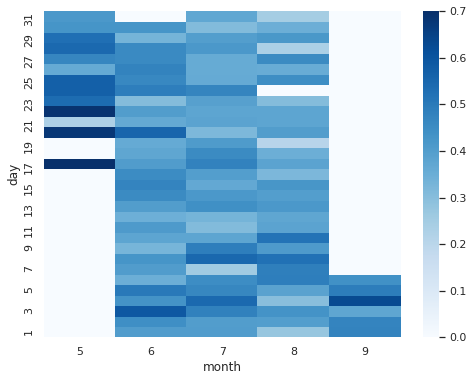

In [ ]:
import matplotlib.pyplot as plt


htmp = new[['month', 'day', 'Score']].copy()
htmp = htmp.pivot_table(index='day', columns='month', values='Score')
htmp = htmp.fillna(0)

fig, ax = plt.subplots(figsize=(8,6)) 
ax = sns.heatmap(htmp,cmap="Blues", ax = ax)
ax.invert_yaxis()

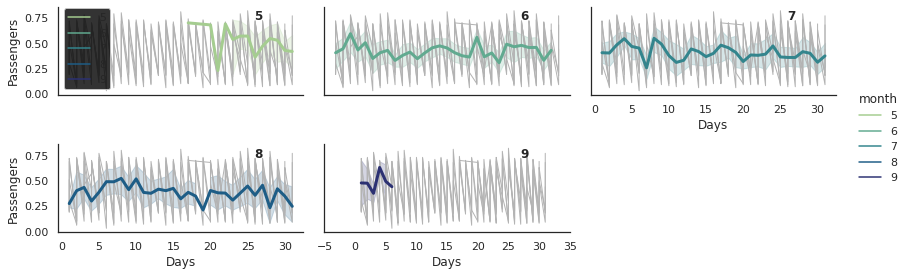

In [ ]:
import seaborn as sns

# Plot each year's time series in its own facet
g = sns.relplot(
    data=new,
    x="day", y="Score", col="month", hue="month",
    kind="line", palette="crest", linewidth=3, zorder=5,
    col_wrap=3, height=2, aspect=2, legend=True,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=new, x="day", y="Score", units="month",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[0::1])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("Days", "Passengers")
g.tight_layout()

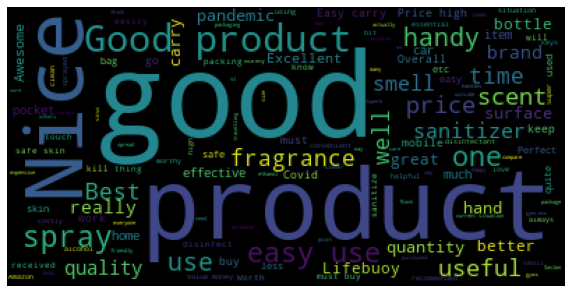

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

plt.figure(figsize = (10, 8), facecolor = None) 
wordcloud2 = WordCloud().generate(' '.join(temp_p['Review_text']))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

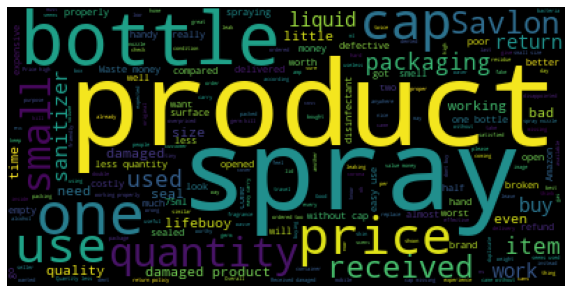

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
comment_words = ' '
stopwords = set(STOPWORDS) 

plt.figure(figsize = (10, 8), facecolor = None) 
wordcloud2 = WordCloud().generate(' '.join(temp_n['Review_text']).replace("good",""))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()